# Multivariate

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Preamble

In this preamble, we load the **gstlearn** library.

In [2]:
import gstlearn as gl
import gstlearn.plot as gp
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request

flagInternetAvailable = True ## Set to false if no internet

ndim = 2
gl.defineDefaultSpace(gl.ESpaceType.RN, ndim)
gl.OptCst.define(gl.ECst.NTCAR, 15)
gp.setDefaultGeographic(dims=[8,8])

We load the data bases containing the observations (`dat`) and the target points (`target`).

In [3]:
## Load observations
fileNF='Scotland_Temperatures.NF'
if flagInternetAvailable:
    temp_nf, head = urllib.request.urlretrieve('https://soft.minesparis.psl.eu/gstlearn/data/Scotland/'+fileNF,'./'+fileNF)
else:
    temp_nf='./'+fileNF
dat = gl.Db.createFromNF(temp_nf)
### Change variable name
dat.setName("*temp", "Temperature")

## Load grid
fileNF='Scotland_Elevations.NF'
if flagInternetAvailable:
    elev_nf, head = urllib.request.urlretrieve('https://soft.minesparis.psl.eu/gstlearn/data/Scotland/'+fileNF,'./'+fileNF)
else:
    elev_nf='./'+fileNF
target = gl.DbGrid.createFromNF(elev_nf)

The `target` data base a (grid) map of the elevation across Scotland.b

In [4]:
target


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 4
Maximum Number of UIDs       = 4
Total number of samples      = 11097
Number of active samples     = 3092

Grid characteristics:
---------------------
Origin :          65.000        535.000
Mesh   :           4.938          4.963
Number :              81            137

Variables
---------
Column = 0 - Name = Longitude - Locator = x1
Column = 1 - Name = Latitude - Locator = x2
Column = 2 - Name = Elevation - Locator = f1
Column = 3 - Name = inshore - Locator = sel

Let us plot its contents

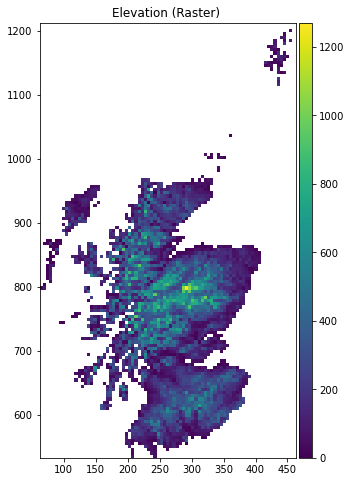

In [5]:
ax = target.plot("Elevation", flagLegendRaster=True)

The `dat` data base contains 236 (point) samples of two variables across Scotland: elevation and temperature.

In [6]:
dat


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 5
Maximum Number of UIDs       = 5
Total number of samples      = 236

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = Longitude - Locator = x1
Column = 2 - Name = Latitude - Locator = x2
Column = 3 - Name = Elevation - Locator = NA
Column = 4 - Name = Temperature - Locator = z1

We can use the `dbStatisticsPrint` function to compute statistics on variables of a `Db`. We specify 

* the `Db` of interest (argument `db`),
* a vector containing the names of the variables of interest (argument `names`),
* the information we want to have on the variable (argument `oper`). This last argument is set through a `EStatOption` object (run `EStatOption_printAll()` for the full list)
* a flag `flagMono` allowing to specify whether we want to compute the statistics for each variable separately (`flagMono=TRUE`), or whether we want to compute "filtered" statistics (`flagMono=FALSE`). In the latter case, the following table is returned: the entry at the i-th row and j-th column contains the statistics of the i-th variable in `names`, computed for the points where `j`-th variable is defined 

For instance, let us count the number of observations of each variable using the `dbStatisticsPrint`. 

In [7]:
gl.dbStatisticsPrint(db=dat, names=["Elevation", "Temperature"],
                     opers=[gl.EStatOption.NUM],flagIso = False,
                     title="Number of observations")


 Number of observations
 ----------------------
                       Number 
 Elevation                236 
 Temperature              151 
 
 

Since the `Db` `dat` contains 236 samples, we can conclude that the `Elevation` variable is defined at every point, but not the `Temperature` variable. Similarly, we can compute the mean of each variable in the observation data base.

In [8]:
gl.dbStatisticsPrint(db=dat, names=["Elevation", "Temperature"],
                     opers=[gl.EStatOption.MEAN],flagIso = False,
                     title="Mean of observations")


 Mean of observations
 --------------------
                         Mean 
 Elevation            146.441 
 Temperature            2.815 
 
 

Finally, we can compute the mean elevation `target` data base to compare it to the one in the observation data base.

In [9]:
gl.dbStatisticsPrint(db=target, names=["Elevation"],
                     opers=[gl.EStatOption.MEAN],flagIso = True,
                     title="Mean")


 Mean
 ----
                       Mean 
 Elevation          241.152 
 
 

We can then compute the filtered means for the `Elevation` and `Temperature` variables as follows:

In [10]:
tab = gl.dbStatisticsMultiT(db=dat, names=["Elevation", "Temperature"],
                         oper=gl.EStatOption.MEAN,flagMono = False)
tab.setTitle("Mean of observations")
tab


Mean of observations
--------------------
- Number of Rows    = 2
- Number of Columns = 2

                      Elevation     Temperature
      Elevation         146.441          87.974
    Temperature           2.815           2.815

As explained above, the first row of the table contains contains means of the `Elevation` variable. The first one corresponds to the  mean of the `Elevation` variable over all the locations where it is defined, and the second one corresponds to the mean of the `Elevation` variable over all the location where the `Temperature` variable is defined. Hence, we see that the points where the temperature is observed have an average elevation (87.97351)  that is significantly lower than the average elevation in Scotland (241.152), meaning that they are located at relatively low altitudes within the Scottish landscape. 

To confirm that, we plot the points where the temperature is sampled on top of the elevation map of Scotland.

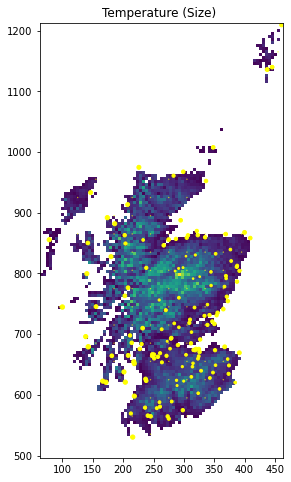

In [11]:
ax = target.plot(name_raster="Elevation")
ax = dat.plot(name_size="Temperature", color="yellow", sizmin=0.1, sizmax=20)

From observing this last plot, it seems like the bigger points (corresponding to high temperatures) are located where the elevation is smaller: this seems to hint (confirm?) that the temperature is negatively correlated with the elevation. To corroborate this, we plot a correlation plot between the two variables.

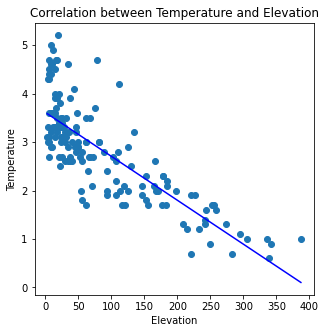

In [12]:
ax = gp.correlation(dat, namex="Elevation", namey="Temperature", asPoint=True, regrLine=True)
ax.decoration(title="Correlation between Temperature and Elevation")

To end this preamble, we create a "neighborhood" object specifying a unique neighborhood, which we will use throughout the course.

In [13]:
uniqueNeigh = gl.NeighUnique.create()

## Working with polynomial trends (intrinsic model)

### Fitting a model with a polynomial trend 

To illustrate our purpose, let us fit a model onto the temperature observations in the `dat` data base. To do so, we start by computing an experimental directional variogram `vario_raw2dir` of the "raw" temperature observations, along two directions ($0^{\circ}\text{C}$ and $90^{\circ}\text{C}$).

In [14]:
varioparam = gl.VarioParam.createMultiple(ndir=2, npas=30, dpas=10)
vario_raw2dir = gl.Vario(varioparam, dat)
err = vario_raw2dir.compute()

When plotting the experimental variograms, we notice that in one of the directions, the variogram does not reach a plateau. This suggests that a non-stationary model could be more suited for the analysis of these temperature observations.

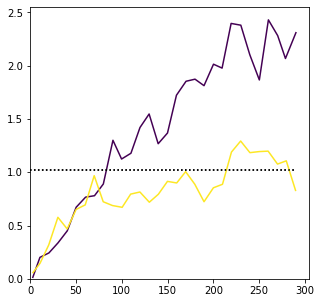

In [15]:
ax = gp.varmod(vario_raw2dir)

Hence, we move to a model for the data where the temperature $Z$ at each location is considered to have a polynomial trend, i.e. we can write, for any location $x$,
$$ Z(x) = P(x) + \varepsilon(x)$$
where $P$ is a polynomial function of the coordinates $x$, and $\varepsilon$ denotes stationary residuals. This model can also be referred to as an intrinsic model. 

It is possible to directly compute the experimental variogram of the residuals $\varepsilon$. To do so, we start by creating a `Model` object in which we specify, through the `setDriftIRF` method, the (maximal) degree of the polynomial trend `P`. 

Then, computing the (possibly directional) experimental variogram of the residuals is done in the same way as for an "ordinary" experimental variogram, the only difference being that we now add in the `compute` method of the `Vario` class, the `Model` object specifying the polynomial trend (argument `model`). Then, the methods takes care of filtering out of the observations a polynomial trend of the specified degree, before computing the experimental variogram on the remaining residuals.

For instance, if we want to compute an experimental variogram of the residuals from a model with a linear trend (polynomial of degree 1), then we can run the following commands

In [16]:
## Create model and set polynomial drift of degree 1
polDriftModel = gl.Model.create()
err = polDriftModel.setDriftIRF(1)

# Compute variogram of residuals
vario_res2dir = gl.Vario(varioparam, dat)
err = vario_res2dir.compute(model=polDriftModel)

If we now plot the experimental variograms computed on the raw data (dotted lines) and on the residuals from the intrinsic model (dashed line), we see that in the latter case, we now reach a plateau in both directions.

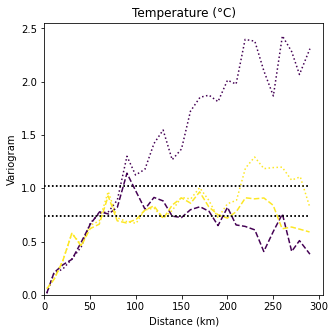

In [17]:
ax = gp.varmod(vario_raw2dir, linestyle='dotted')
ax = gp.varmod(vario_res2dir, linestyle='dashed')
ax.decoration(title="Temperature (°C)", xlabel = "Distance (km)", ylabel = "Variogram")

Finally, to compute the coefficients of the polynomial trend from the intrinsic model defined above, we can use the function `regression`. This function allows to perform linear regressions on variables defined in a data base. 

For instance, to fit a linear trend on the temperature observations in the `dat` data base, we specify the name of response variable (argument `name0`) and the drift model (argument `model`), and set the argument `mode=2` to specify that we would like to compute a regression defined from a drift model. Finally we set the argument `verbose=TRUE` to print the results.


In [18]:
err = gl.regression(dat, name0="Temperature", mode=2, model=polDriftModel, verbose=True)


 Linear Regression
 -----------------
 - Calculated on 151 active values
 - Explanatory Variable #1 = 3.521360
 - Explanatory Variable #2 = -0.007466
 - Explanatory Variable #3 = 0.001978
 - Initial variance        = 1.019788
 - Variance of residuals   = 0.735557
 

Note: The regression results are stored in an object. We can access the coefficients through the slot `coeffs`, the initial variance of the data through the slot `variance` and the variance of the residuals through the slot `varres`.

Going back to our example, it is now time to fit our model with polynomial drift. We can now fit that model on the experimental variorgram using the `fit` method in the usual way.

In [19]:
err = polDriftModel.fit(vario_res2dir,types=[gl.ECov.NUGGET, gl.ECov.EXPONENTIAL, gl.ECov.CUBIC])

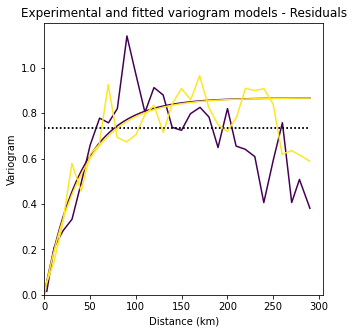

In [20]:
ax = gp.varmod(vario_res2dir, polDriftModel)
ax.decoration(title="Experimental and fitted variogram models - Residuals", 
              xlabel = "Distance (km)", ylabel = "Variogram")

### Universal Kriging

To work with universal kriging, it suffices to call the `kriging` (to compute predictions) or `xvalid` (to perform cross-validation) with a `Model` object that includes polynomial drift functions. This model should be fitted on a experimental variogram computed on residuals where the polynomial trend has been filtered out. 

To perform cross-validation using Universal Kriging, we simply call the `xvalid` function with the model we just fitted on the residuals. Note: we specify the `namconv` argument so that the cross-validation outputs are added to the data base with a name starting with "CV_UK", and without changing the locators in the data base.

In [21]:
err = gl.xvalid(dat, model=polDriftModel, neigh=uniqueNeigh, 
                namconv=gl.NamingConvention.create(prefix="CV_UK",flag_locator=False))

The mean Mean Squared cross-validation and standardized errors of the universal kriging predictor are:

In [22]:
mse=np.nanmean(np.square(dat.getColumn("CV_UK*esterr*")))
print("Mean squared cross-validation error:", round(mse,3))

mse=np.nanmean(np.square(dat.getColumn("CV_UK*stderr*")))
print("Mean squared standardized error:", round(mse,3))

Mean squared cross-validation error: 0.251
Mean squared standardized error: 0.855


Finally, we perform an universal kriging prediction of the temperature on the `target` grid using the model fitted on the residuals. 

In [23]:
err = gl.kriging(dbin=dat, dbout=target, model=polDriftModel, 
              neigh=uniqueNeigh,
              namconv=gl.NamingConvention.create(prefix="UK"))

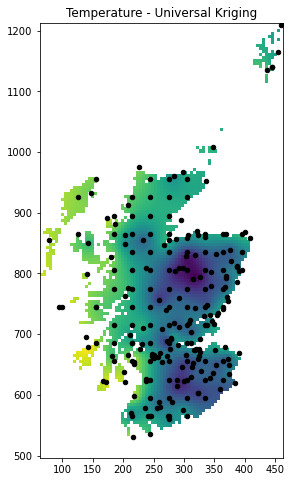

In [24]:
ax = target.plot(name_raster="UK*estim")
ax = dat.plot(flagCst=True, color="black")
ax.decoration(title="Temperature - Universal Kriging")

We compute some statistics on the predicted values using the `dbStatisticsMonoT` function. 

In [25]:
opers = gl.EStatOption.fromKeys(["NUM","MINI","MAXI","MEAN","STDV"])

gl.dbStatisticsPrint(target, names = (["UK.T*"]), opers=opers,
                    title="Statistics on the Universal Kriging:")


 Statistics on the Universal Kriging:
 ------------------------------------
                                Number          Minimum          Maximum             Mean         St. Dev. 
 UK.Temperature.estim             3092            0.613            5.051            2.841            0.923 
 UK.Temperature.stdev             3092            0.083            0.919            0.555            0.138 
 
 

### Comparison with ordinary kriging

Let us compare the results obtained when considering a polynomial trend in the model, with the case where we work directly on the "raw" temperature observations.

To do so, we start by fitting a model on the experimental variogram of raw temperature observations.

In [26]:
fitmod_raw = gl.Model()
err = fitmod_raw.fit(vario_raw2dir,
                    types=[gl.ECov.NUGGET, gl.ECov.EXPONENTIAL, gl.ECov.CUBIC, gl.ECov.LINEAR])

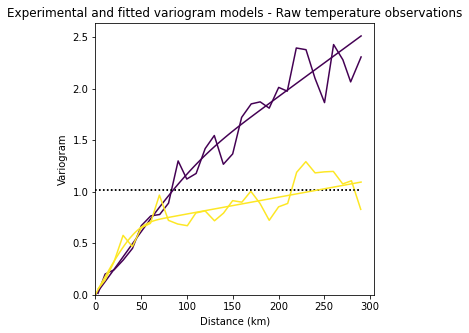

In [27]:
ax = gp.varmod(vario_raw2dir, fitmod_raw)
ax.decoration(title="Experimental and fitted variogram models - Raw temperature observations", 
              xlabel = "Distance (km)", ylabel = "Variogram")

We then perform a cross-validation of the fitted model using Ordinary Kriging, and calculate the Mean Squared cross-validation and standardized errors. Since we want to use ordinary kriging, we add a constant drift to the model before calling the `xvalid` function.

In [28]:
## Add constant drift to model
err = fitmod_raw.addDrift(gl.Drift1())

## Compute cross-validation
err = gl.xvalid(dat, model=fitmod_raw, 
             neigh=uniqueNeigh,
             namconv=gl.NamingConvention.create(prefix="CV_OK",flag_locator=False))

In [29]:
mse=np.nanmean(np.square(dat.getColumn("CV_OK*esterr*")))
print("Mean squared cross-validation error:", round(mse,3))

mse=np.nanmean(np.square(dat.getColumn("CV_OK*stderr*")))
print("Mean squared standardized error:", round(mse,3))

Mean squared cross-validation error: 0.254
Mean squared standardized error: 1.117


We observe that the mean squared errors that we obtain are larger than the one resulting from the intrinsic model. 

We now perform an ordinary kriging prediction of the temperature on the `target` grid using the model fitted on the raw observations, compute statistics on the predicted values using the `dbStatisticsMonoT` function. 


In [30]:
err = gl.kriging(dbin=dat, dbout=target, model=fitmod_raw, 
              neigh=uniqueNeigh,
              namconv=gl.NamingConvention.create(prefix="OK"))

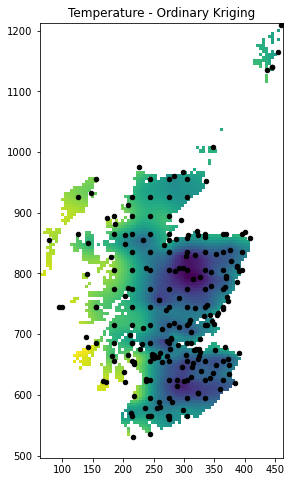

In [31]:
ax = target.plot(name_raster="OK*estim")
ax = dat.plot(flagCst=True, color="black")
ax.decoration(title="Temperature - Ordinary Kriging")

In [32]:
gl.dbStatisticsPrint(target, names = (["OK.T*"]), opers=opers,
                    title="Statistics on the Ordinary Kriging:")


 Statistics on the Ordinary Kriging:
 -----------------------------------
                                Number          Minimum          Maximum             Mean         St. Dev. 
 OK.Temperature.estim             3092            0.604            5.083            2.834            0.954 
 OK.Temperature.stdev             3092            0.077            0.992            0.492            0.145 
 
 

Finally, we plot a correlation plot between the ordinary and universal kriging predictions, compare their respective statistics.

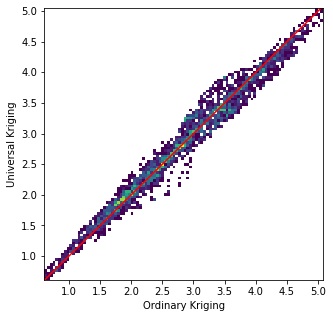

In [33]:
ax = gp.correlation(target, namex="OK*estim", namey="UK*estim", bissLine=True, bins=100,cmin=1)
ax.decoration(xlabel="Ordinary Kriging",ylabel="Universal Kriging")

In [34]:
gl.dbStatisticsPrint(target, names = (["OK.T*estim", "UK.T*estim"]), opers=opers,
                    title="Comparison between Ordinary and Universal kriging predictions:")


 Comparison between Ordinary and Universal kriging predictions:
 --------------------------------------------------------------
                                Number          Minimum          Maximum             Mean         St. Dev. 
 OK.Temperature.estim             3092            0.604            5.083            2.834            0.954 
 UK.Temperature.estim             3092            0.613            5.051            2.841            0.923 
 
 

## Multivariate Models and Cokriging

To create and work with multivariate models, we simply need to work with `Db` objects containing more than one variable with a `z` locator. All the variables with a `z` locator will be considered as part of the multivariate model. Then, the same commands as in the monovariate case can be used to create and fit experimental variograms, and to perform (co)kriging predictions. 

Let us illustrate our point with our running example. We would like now to consider a bivariate model of the temperature and the elevation. To do so, we simply allocate, in the observation data base `dat`, a `z` locator to both variables using the $setLocators$  method.

In [35]:
dat.setLocators(names=["Temperature", "Elevation"], locatorType=gl.ELoc.Z)
dat


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 9
Maximum Number of UIDs       = 9
Total number of samples      = 236

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = Longitude - Locator = x1
Column = 2 - Name = Latitude - Locator = x2
Column = 3 - Name = Elevation - Locator = z2
Column = 4 - Name = Temperature - Locator = z1
Column = 5 - Name = CV_UK.Temperature.esterr - Locator = NA
Column = 6 - Name = CV_UK.Temperature.stderr - Locator = NA
Column = 7 - Name = CV_OK.Temperature.esterr - Locator = NA
Column = 8 - Name = CV_OK.Temperature.stderr - Locator = NA

### Fitting a bivariate model

To create experimental (directional) variograms and cross-variograms, we use the same commands as in the monovariate case: since the data base `dat` now contains two variables with a `z` locator, the `compute` method automatically computes both variograms and cross-variograms for these variables.

In [36]:
varioexp2var = gl.Vario.create(varioparam, dat)
err = varioexp2var.compute()

We can then plot the experimental variograms and cross-variograms with a simple command: the plot in the i-th row and j-th column corresponds to the cross-variogram between the variables with locators `zi` and `zj` (hence the diagonal plots correspond to the variograms of each variable).

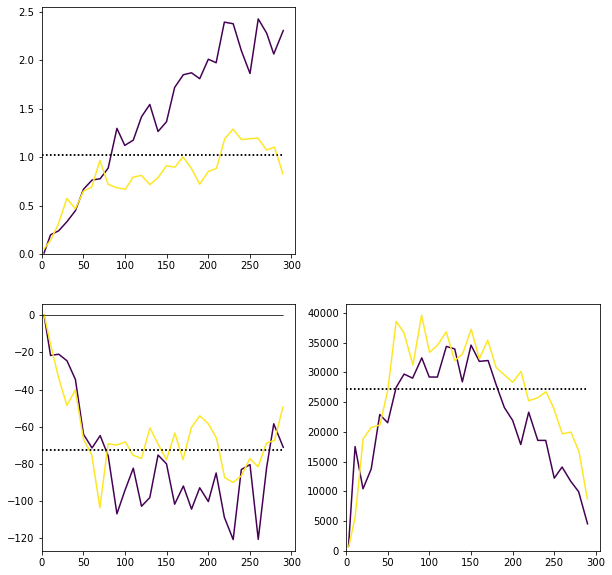

In [37]:
ax=gp.varmod(varioexp2var)

To fit a model on the experimental variograms and cross-variograms, we use the same commands as in the monovariate case.

In [38]:
fitmod2var = gl.Model()
err = fitmod2var.fit(varioexp2var,
                     types=[gl.ECov.NUGGET, gl.ECov.EXPONENTIAL, gl.ECov.CUBIC, gl.ECov.LINEAR])

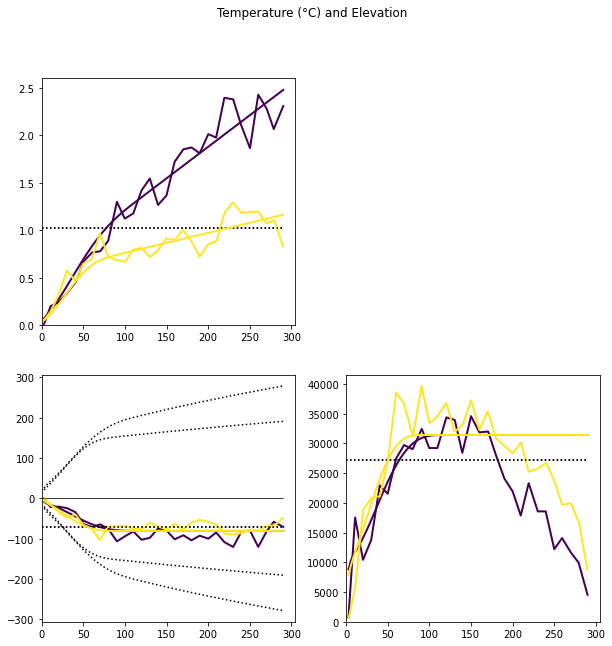

In [39]:
ax = gp.varmod(varioexp2var, fitmod2var, lw=2)
gp.decoration(ax,title="Temperature (°C) and Elevation")

### Cokriging predictions and cross-validation

Since cokriging can be time-consuming in Unique Neighborhood, we create a small moving neighborhood for demonstration.

In [40]:
movingNeigh = gl.NeighMoving.create(radius = 1000, nmaxi = 10)

To perform a cross-validation of the bivariate model using co-kriging, we use the  same commands as in the monovariate case. Then cross-validation errors are computed for each variable of the multivariate model (hence for both the Temperature and the Elevation in our case).

In [41]:
err = gl.xvalid(dat, model=fitmod2var,
             neigh=movingNeigh,
             namconv=gl.NamingConvention.create(prefix="CV_COK",flag_locator=False))

We obtain the following Mean Squared Errors for the temperature.

In [42]:
mse=np.nanmean(np.square(dat.getColumn("CV_COK.Temperature*esterr*")))
print("Mean squared cross-validation error:", round(mse,3))

mse=np.nanmean(np.square(dat.getColumn("CV_COK.Temperature*stderr*")))
print("Mean squared standardized error:", round(mse,3))

Mean squared cross-validation error: 0.281
Mean squared standardized error: 1.254


We obtain the following Mean Squared Errors for the elevation.

In [43]:
mse=np.nanmean(np.square(dat.getColumn("CV_COK.Elevation*esterr*")))
print("Mean squared cross-validation error:", round(mse,3))

mse=np.nanmean(np.square(dat.getColumn("CV_COK.Elevation*stderr*")))
print("Mean squared standardized error:", round(mse,3))

Mean squared cross-validation error: 17347.961
Mean squared standardized error: 1.179


Similarly, to compute cokriging predictions on the grid, we use the same syntax as in monovariate case: once again, a predictor for each variable in the multivariate model is produced. (Note: we revert back to a unique neighborhood to compare with the predictors previously introduced).

In [44]:
err = gl.kriging(dbin=dat, dbout=target, model=fitmod2var, 
              neigh=uniqueNeigh,
              namconv=gl.NamingConvention.create(prefix="COK"))

We can then represent the cokriging predictor for the temperature.

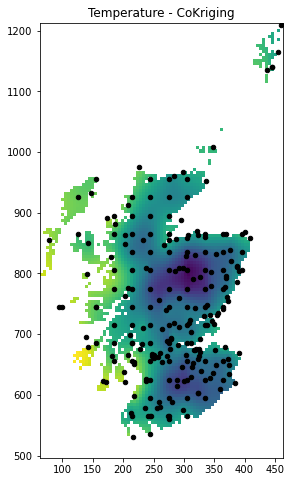

In [45]:
ax = target.plot(name_raster="COK.Temp*estim")
ax = dat.plot(flagCst=True, color="black")
ax.decoration(title="Temperature - CoKriging")

For this predictor, we get the following statistics:

In [46]:
gl.dbStatisticsPrint(target, names = (["COK.T*"]), opers=opers,
                    title="Statistics on the CoKriging predictions")


 Statistics on the CoKriging predictions
 ---------------------------------------
                                 Number          Minimum          Maximum             Mean         St. Dev. 
 COK.Temperature.estim             3092            0.202            5.242            2.682            0.979 
 COK.Temperature.stdev             3092            0.231            0.945            0.448            0.109 
 
 

Finally, we compare the cokriging predictor to the ordinary kriging predictor.

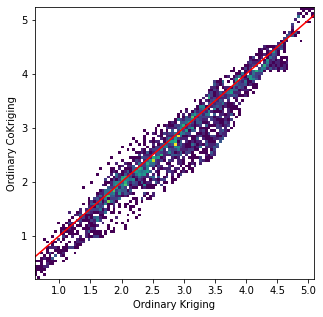

In [47]:
ax = gp.correlation(target, namex="OK.T*estim", namey="COK.T*estim", bissLine=True, bins=100, cmin=1)
ax.decoration(xlabel="Ordinary Kriging",ylabel="Ordinary CoKriging")

In [48]:
gl.dbStatisticsPrint(target, names = (["OK.T*estim", "COK.T*estim"]), opers=opers,
                    title="Comparison between Ordinary and Universal kriging predictions")


 Comparison between Ordinary and Universal kriging predictions
 -------------------------------------------------------------
                                 Number          Minimum          Maximum             Mean         St. Dev. 
 OK.Temperature.estim              3092            0.604            5.083            2.834            0.954 
 COK.Temperature.estim             3092            0.202            5.242            2.682            0.979 
 
 

## Working with residuals

In this section, we assume that the variable of interest $Z$ is modeled (at each location $x$) as
$$ Z(x) = b+a Y(x) + \varepsilon(x)$$
where $Y$ is an auxiliary variable known at every location, $a$ and $b$ are some (unknown) regression coefficients, and $\varepsilon$ denotes stationary residuals. Our goal will be to model and work directly with the residuals $\varepsilon$ (since they are the one who are assumed to be stationary).

In our running example, the variable of interest $Z$ will be the temperature, and the auxiliary variable $Y$ will be the elevation. To compute the coefficients $a$ and $b$ of the linear regression between the temperature and the elevation, we can use once again the `regression` function. We specify the name of response variable (argument `name0`) and the names of the auxiliary variables (argument `names`), and set the argument `mode=0` to specify that we would like to compute a regression defined from the variables with the specified names. We also set the argument `flagCste=TRUE` to specify that we are looking for an affine regression model between the variables (i.e. that includes the bias coefficient `b`).

In [49]:
regr = gl.regression(dat, "Temperature", ["Elevation"], mode=0, flagCste=True)

#Extract coefficients
b = regr.coeffs[0]
a = regr.coeffs[1]

print("Coefficients: b=",round(b,3),"; a=",round(a,5))

Coefficients: b= 3.612 ; a= -0.00906


From these regression coefficients obtained above, we can then compute the residuals explicitly as $ \varepsilon(x)=Z(x) - (b+a Y(x) )$. An alternative method consists in using the `dbRegression` function: this functions fits a regression model, computes the residuals and add them directly on the data base containing the data. The `dbRegression` function is called in a similar way as the `regression` function.

In the next example, we compute the residuals of the linear regression between the temperature and the elevation and add them to the observation data base (with a name starting with "RegRes"and without changing the locators in the data base).

In [50]:
err = gl.dbRegression(dat, "Temperature", ["Elevation"], flagCste=True,
                     namconv = gl.NamingConvention.create("RegRes",flag_locator=False))

We then compute some statistics about these residuals.

In [51]:
gl.dbStatisticsPrint(dat, names = (["RegRes*"]), opers=opers,
                    title="Statistics on the residuals")


 Statistics on the residuals
 ---------------------------
                              Number          Minimum          Maximum             Mean         St. Dev. 
 RegRes.Temperature              151           -1.359            1.795            0.000            0.603 
 
 

Finally we plot a correlation plot between the residuals and the regressor variable (i.e. the elevation).

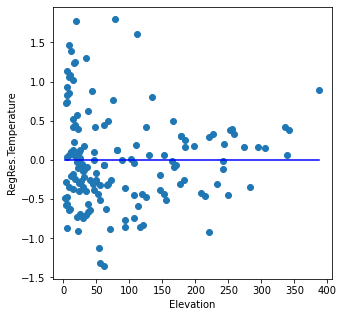

In [52]:
ax = gp.correlation(dat, namex="Elevation", namey="RegRes*",regrLine=True,asPoint=True)

Now that the residuals are explicitly computed and available in the observation data base, we can proceed to work with them as with any other variable.

We start by setting their locator to `z` to specify that they are now our variable of interest within the data base (instead of the raw temperature observations).

In [53]:
dat.setLocator("RegRes*",gl.ELoc.Z, cleanSameLocator=True)

Then we can compute an experimental variogram for the residuals and fit a model on them.

In [54]:
## Compute experimental variogram
varioexpR = gl.Vario(varioparam, dat)
err = varioexpR.compute()

## Fit model
fitmodR = gl.Model()
err = fitmodR.fit(varioexpR,types=[gl.ECov.NUGGET, gl.ECov.SPHERICAL, gl.ECov.LINEAR])

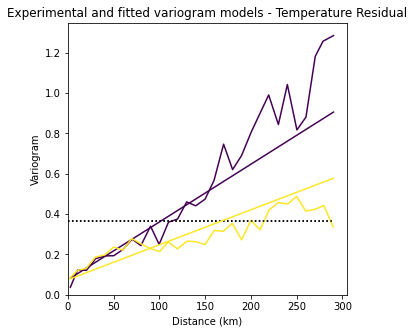

In [55]:
ax = gp.varmod(varioexpR, fitmodR)
ax.decoration(title="Experimental and fitted variogram models - Temperature Residual",
              xlabel = "Distance (km)", ylabel = "Variogram")

Finally, we can compute an kriging prediction of the residuals and plot the results.

In [56]:
##  Add constant drift to model to perform ordinary kriging
err = fitmodR.addDrift(gl.Drift1())

## Compute kriging
err = gl.kriging(dbin=dat, dbout=target, model=fitmodR, 
              neigh=uniqueNeigh,
              namconv=gl.NamingConvention.create(prefix="ROK"))

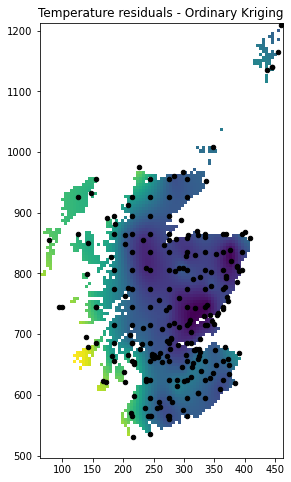

In [57]:
ax = target.plot("ROK*estim")
ax = dat.plot(flagCst=True, color="black")
ax.decoration(title="Temperature residuals - Ordinary Kriging")

Now that the residuals $\varepsilon^{OK}$ are predicted everywhere on the grid (by ordinary kriging), we can compute a predictor $Z^*$ for the temperature by simply adding the back the linear regression part of the model, i.e. by computing

$$
Z^{\star}(x) = b + a Y(x) + \varepsilon^{OK}(x)
$$
We can compute this predictor by directly manipulating the variables of the `target` data base.


In [58]:
## Compute temperature predictor
ROK_estim =  b + a * target["Elevation"] + target["ROK*estim"]

## Add it to data base
uid = target.addColumns(ROK_estim,"KR.Temperature.estim")

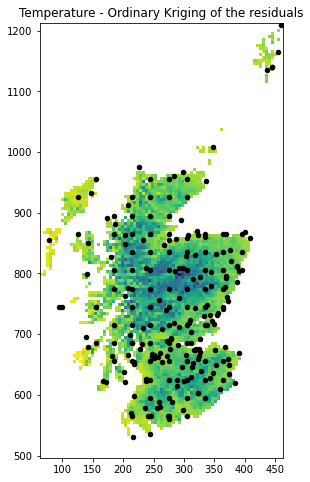

In [59]:
ax = target.plot("KR.T*estim")
ax = dat.plot(flagCst=True, color="black")
ax.decoration(title="Temperature - Ordinary Kriging of the residuals")

Finally, we compare the predictor obtained by kriging of the residuals to the ordinary kriging predictor.

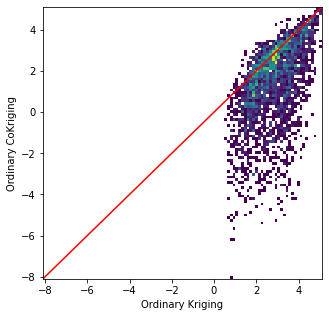

In [60]:
ax = gp.correlation(target, namex="OK.T*estim", namey="KR.T*estim", bissLine=True, bins=100, 
                    flagSameAxes=True, cmin=1)
ax.decoration(xlabel="Ordinary Kriging",ylabel="Ordinary CoKriging")

In [61]:
gl.dbStatisticsPrint(target, names = (["OK.T*estim*", "KR.T*estim"]), opers=opers,
                    title="Comparison between Ordinary and Residual kriging predictions")


 Comparison between Ordinary and Residual kriging predictions
 ------------------------------------------------------------
                                Number          Minimum          Maximum             Mean         St. Dev. 
 OK.Temperature.estim             3092            0.604            5.083            2.834            0.954 
 KR.Temperature.estim             3092           -8.097            5.108            1.445            1.906 
 
 

## Models with External Drifts

In this last section, we investigate how to specify and work with external drifts when modeling data. In a data base, external drifts are identified by allocating a locator `f` to them in the data bases.

For instance, circling back to our running example, let us assume that we would like to model the temperature with an external drift given by the elevation. Then, in the observation data base, we simply need to allocate a `z` locator to the temperature variable and a `f` locator to the elevation variable using the `setLocator` method. Note: we use the flag `cleanSameLocator=TRUE` to make sure that only the variable we specify carries the locator.

In [62]:
## Set `z` locator to temperature
dat.setLocator("Temperature",gl.ELoc.Z,cleanSameLocator=True)

## Set `f` locator to elevation
dat.setLocator("Elevation",gl.ELoc.F,cleanSameLocator=True)

In [63]:
varioKED = gl.Vario(varioparam, dat)

model = gl.Model.create()
model.setDriftIRF(order=0, nfex=1)
err = varioKED.compute(model=model)

Then, defining and fitting the models on the one hand, and performing kriging predictions on the other hand, is done using the same approach as the one described earlier for models with a polynomial trend.

### Fitting  a model 

To create experimental (directional) variograms of the residuals from a model with external drift, we use the same approach as the one described for modeling data with polynomial trends.

First, we create a `Model` object where we specify that we deal with external drifts. This is once again done through the `setDriftIRF` function where we specify:

* the number of external drift variables (argument `nfex`): this is the number of variables with a `f` locator the we want to work with 
* the maximal degree of the polynomial trend in the data (argument `order`):  setting `order=0` allows to add a constant drift to the model, and setting `order` to a value $n$ allows to add all the monomial functions of the coordinates of order up to $n$ as external drifts (on top of the `nfex` external drift variables)

Circling back to our example, we create a model with a single external drift (the elevation), and add a constant drift (that basically acts like a bias term). 

In [64]:
EDmodel = gl.Model()
EDmodel.setDriftIRF(order = 0, nfex = 1)

Then, to compute the experimental variogram, we use the same commands as in the case of polynomial trends: we create a `Vario` object from the data base containing the data, and call the `compute` method with the model we just created. The experimental variogram is computed on the residuals obtained after "filtering out" the (linear) effect of the drift  variables (and possibly of a polynomial trend if specified in the model). 

In [65]:
varioKED = gl.Vario(varioparam, dat)
err = varioKED.compute(model=EDmodel)

As a reference, we plot the experimental variograms computed on the raw temperature data (dotted lines) and on the residuals from the model with external drift (dashed line).

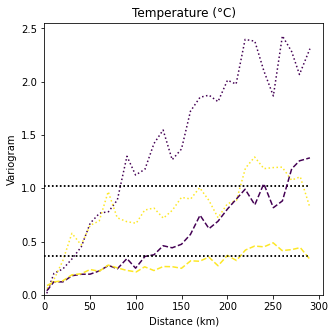

In [66]:
ax = gp.varmod(vario_raw2dir, linestyle='dotted')
ax = gp.varmod(varioKED, linestyle='dashed')
ax.decoration(title="Temperature (°C)",
              xlabel = "Distance (km)", ylabel = "Variogram")

Finally, we fit our model with external drift using the `fit` method (which we call on the experimental variogram of residuals).

In [67]:
err = EDmodel.fit(varioKED,types=[gl.ECov.NUGGET, gl.ECov.CUBIC, gl.ECov.GAUSSIAN])

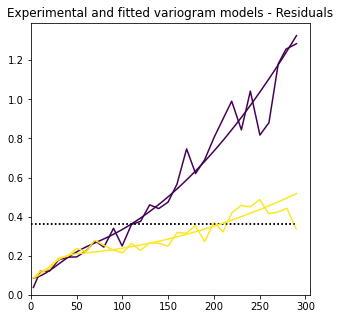

In [68]:
ax = gp.varmod(varioKED, EDmodel)
ax.decoration(title="Experimental and fitted variogram models - Residuals")

### Cross-Validation and predictions

To perform a cross-validation or predictions using kriging with External Drifts, we simply call the `xvalid` and `kriging` functions with models where external drifts are specified. 

For instance, in our example, a cross-validation is performed by calling the `xvalid` function with the model we just fitted.

In [69]:
err = gl.xvalid(dat, model=EDmodel, 
             neigh=uniqueNeigh,
             namconv=gl.NamingConvention.create(prefix="CV_KED",flag_locator=False))

The mean Mean Squared cross-validation and standardized errors of the resulting kriging predictor are:

In [70]:
mse=np.nanmean(np.square(dat.getColumn("CV_KED*esterr*")))
print("Mean squared cross-validation error:", round(mse,3))

mse=np.nanmean(np.square(dat.getColumn("CV_KED*stderr*")))
print("Mean squared standardized error:", round(mse,3))

Mean squared cross-validation error: 0.172
Mean squared standardized error: 1.143


Finally, we perform an kriging prediction of the temperature on the `target`. 

In [71]:
err = gl.kriging(dbin=dat, dbout=target, model=EDmodel, 
              neigh=uniqueNeigh,
              namconv=gl.NamingConvention.create(prefix="KED"))

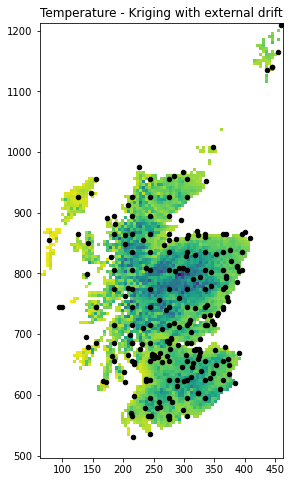

In [72]:
ax = target.plot("KED.T*estim")
ax = dat.plot(flagCst=True, color="black")
ax.decoration(title="Temperature - Kriging with external drift")

For this predictor, we get the following statistics:

In [73]:
gl.dbStatisticsPrint(target, names = (["KED.T*"]), opers=opers,
                    title="Statistics on the Kriging with External Drift predictions")


 Statistics on the Kriging with External Drift predictions
 ---------------------------------------------------------
                                 Number          Minimum          Maximum             Mean         St. Dev. 
 KED.Temperature.estim             3092           -6.004            4.773            1.778            1.540 
 KED.Temperature.stdev             3092            0.312            0.615            0.396            0.051 
 
 

### Comparing the various kriging predictions

First, we create a correlation plot between the ordinary kriging predictions, and the kriging with external drift (KED) predictions. Note that negative Estimates are present when using External Drift.

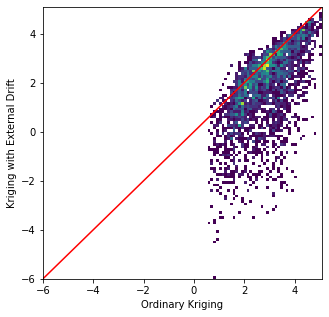

In [74]:
ax = gp.correlation(target, namex="OK.T*estim", namey="KED.T*estim", bissLine=True, bins=100,
                    flagSameAxes=True, cmin=1)
ax.decoration(xlabel="Ordinary Kriging",ylabel="Kriging with External Drift")

We then compare the  Mean Squared cross-validation errors obtained in for the different kriging predictions (UK=Universal kriging, OK=Ordinary kriging, COK= Cokriging, KED= Kriging with external drift, KR=Kriging of residuals).

In [75]:
gl.dbStatisticsPrint(dat, names = (["CV*.Temperature.esterr*"]), opers=opers,
                    title="Mean-squared cross-validation errors")


 Mean-squared cross-validation errors
 ------------------------------------
                                     Number          Minimum          Maximum             Mean         St. Dev. 
 CV_UK.Temperature.esterr               151           -1.713            1.477           -0.003            0.501 
 CV_OK.Temperature.esterr               151           -1.354            1.508           -0.012            0.504 
 CV_COK.Temperature.esterr              151           -1.600            1.652           -0.118            0.517 
 CV_KED.Temperature.esterr              151           -1.577            1.001           -0.009            0.414 
 
 

We then compare various statistics computed for each predictor.

In [76]:
gl.dbStatisticsPrint(target, names = (["*.Temperature.estim"]), opers=opers,
                    title="Statistics of the predictors")


 Statistics of the predictors
 ----------------------------
                                        Number          Minimum          Maximum             Mean         St. Dev. 
 UK.Temperature.estim                     3092            0.613            5.051            2.841            0.923 
 OK.Temperature.estim                     3092            0.604            5.083            2.834            0.954 
 COK.Temperature.estim                    3092            0.202            5.242            2.682            0.979 
 ROK.RegRes.Temperature.estim             3092           -0.771            1.586            0.019            0.455 
 KR.Temperature.estim                     3092           -8.097            5.108            1.445            1.906 
 KED.Temperature.estim                    3092           -6.004            4.773            1.778            1.540 
 
 

Finally, we compare various statistics computed for the standard-deviation of each predictor.

In [77]:
gl.dbStatisticsPrint(target, names = (["*.Temperature.stdev"]), opers=opers,
                    title="Statistics of the standard-deviation of each predictors")


 Statistics of the standard-deviation of each predictors
 -------------------------------------------------------
                                        Number          Minimum          Maximum             Mean         St. Dev. 
 UK.Temperature.stdev                     3092            0.083            0.919            0.555            0.138 
 OK.Temperature.stdev                     3092            0.077            0.992            0.492            0.145 
 COK.Temperature.stdev                    3092            0.231            0.945            0.448            0.109 
 ROK.RegRes.Temperature.stdev             3092            0.304            0.504            0.362            0.031 
 KED.Temperature.stdev                    3092            0.312            0.615            0.396            0.051 
 
 